In [41]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# ---------------------------------------------------------------------------
# Projektpfad setzen, damit "model" importierbar ist
# ---------------------------------------------------------------------------
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from model.simulation import (
    load_scenario,
    simulate_load_profile,
    load_vehicle_profiles_from_csv,  # falls du weiter oben die Flotte anschauen willst
)

In [42]:

# ---------------------------------------------------------------------------
# Szenario laden und Simulation durchführen
# ---------------------------------------------------------------------------
scenario_name = "logistics_center"            # gewünschtes Szenario
scenario_path = f"../scenarios/{scenario_name}.yaml"

scenario = load_scenario(scenario_path)
timestamps, load_kw, sessions = simulate_load_profile(scenario)

In [43]:
# ---------------------------------------------------------------------------
# Kontrollen: Standorttyp, Zeitbereich und Simulationshorizont
# ---------------------------------------------------------------------------
print("Verwendetes Szenario:", scenario_name)
print(f"Erster Timestamp: {timestamps[0]}")
print(f"Letzter Timestamp: {timestamps[-1]}")
print(f"Simulationshorizont: {scenario['simulation_horizon_days']} Tage")

# ---------------------------------------------------------------------------
# Überblick: Anzahl Sessions und Beispiel-Sessions
# ---------------------------------------------------------------------------
print("\nAnzahl Ladesessions im Simulationshorizont:", len(sessions))
print("\nBeispiel-Sessions (erste 10):")

for s in sessions[:10]:
    print(
        f"Fahrzeug: {s['vehicle_name']}, "
        f"Ankunft: {s['arrival_time']}, "
        f"Abfahrt: {s['departure_time']}, "
        f"Kapazität: {s['battery_capacity_kwh']} kWh, "
        f"geladene Energie: {s['delivered_energy_kwh']:.1f} kWh, "      #NEU
        f"Restbedarf: {s['energy_required_kwh']:.1f} kWh"           # NEU
    )

# ---------------------------------------------------------------------------
# Auswertung: welche Fahrzeuge wurden wie oft geladen?
# ---------------------------------------------------------------------------
vehicle_names = [s["vehicle_name"] for s in sessions]
counts = Counter(vehicle_names)

print("\nVerwendete Fahrzeuge im Simulationshorizont:")
for model, n in counts.items():
    print(f"- {model}: {n} Sessions")

Verwendetes Szenario: logistics_center
Erster Timestamp: 2025-05-22 00:00:00
Letzter Timestamp: 2025-05-23 23:50:00
Simulationshorizont: 2 Tage

Anzahl Ladesessions im Simulationshorizont: 27

Beispiel-Sessions (erste 10):
Fahrzeug: Zafira e, Ankunft: 2025-05-22 06:22:07.566722, Abfahrt: 2025-05-22 09:02:02.114609, Kapazität: 75.0 kWh, geladene Energie: 11.9 kWh, Restbedarf: 38.0 kWh
Fahrzeug: ProAce Electric, Ankunft: 2025-05-22 06:44:48.464835, Abfahrt: 2025-05-22 13:20:51.994629, Kapazität: 75.0 kWh, geladene Energie: 0.0 kWh, Restbedarf: 56.9 kWh
Fahrzeug: e Expert, Ankunft: 2025-05-22 07:15:22.822079, Abfahrt: 2025-05-22 12:52:11.861827, Kapazität: 50.0 kWh, geladene Energie: 0.0 kWh, Restbedarf: 37.5 kWh
Fahrzeug: Zafira e, Ankunft: 2025-05-22 07:57:48.949863, Abfahrt: 2025-05-22 10:31:33.022781, Kapazität: 75.0 kWh, geladene Energie: 0.0 kWh, Restbedarf: 46.5 kWh
Fahrzeug: e Expert, Ankunft: 2025-05-22 08:42:59.598988, Abfahrt: 2025-05-22 18:42:59.598988, Kapazität: 50.0 kWh, ge

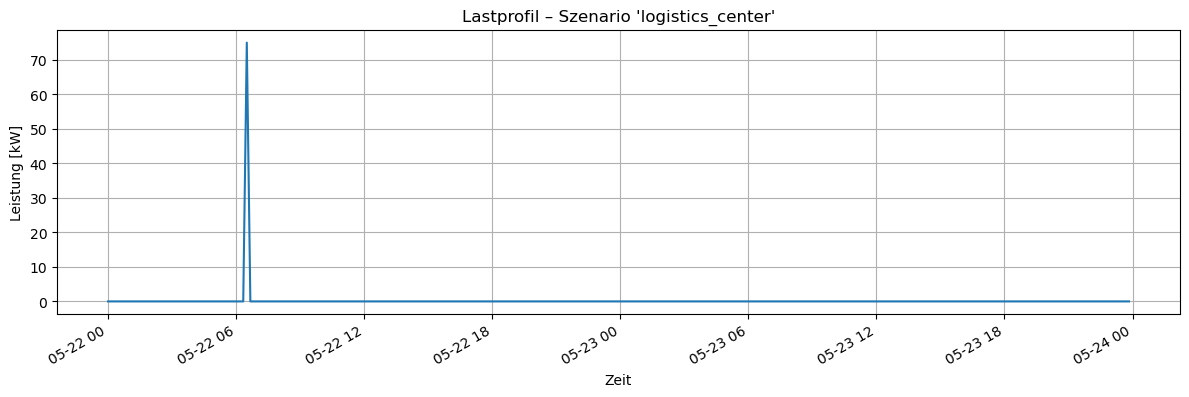

In [44]:
# ---------------------------------------------------------------------------
# 3) Lastprofil als Diagramm
# ---------------------------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(timestamps, load_kw)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(f"Lastprofil – Szenario '{scenario_name}'")
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()


In [ ]:
timestamps, load_kw, sessions, charging_counts = simulate_load_profile(scenario)

max_parallel_present = max(
    sum(1 for s in sessions if s["arrival_time"] <= t < s["departure_time"])
    for t in timestamps
)

print("Max. gleichzeitig anwesend:", max_parallel_present)
print("Max. gleichzeitig ladend:", max(charging_counts))
print("Ladepunkte:", scenario["site"]["number_chargers"])


ValueError: not enough values to unpack (expected 4, got 3)